In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import os
from datetime import datetime
from tqdm import tqdm_notebook

from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

Идеи:
- среднее время пребывания за сессию на (top30_alice & top30_non_alice)
- количество посещений в сессии top30_alice
- количество посещений в сессии top30_non_alice
- уменьшить размер обучающей выборки (старые данные)

In [2]:
def write_to_submission_file(predicted_proba, 
                             filename, 
                             out_folder='./submissions', 
                             timestamp=False,
                             target='target', 
                             index_label="session_id"):
    
    if timestamp:
        out_filename = '{}_{}.csv'.format(filename, datetime.now().strftime('%m%d_%H%M'))
    else:
        out_filename = '{}.csv'.format(filename)
        
    out_full_path = os.path.join(out_folder, out_filename)    
    
    predicted_df = pd.DataFrame(predicted_proba[:, 1], 
                                index=np.arange(1, predicted_proba.shape[0] + 1), 
                                columns=[target])
    
    predicted_df.to_csv(out_full_path, index_label=index_label)

### data preprocess

In [3]:
train_df = pd.read_csv('./data/train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('./data/test_sessions.csv', index_col='session_id')

In [4]:
print('train_df:', train_df.shape)
print('test_df:', test_df.shape)

train_df: (253561, 21)
test_df: (82797, 20)


In [5]:
train_df = train_df.sort_values('time1', axis=0, ascending=True)

In [6]:
train_test_split_idx = train_df.shape[0]

X_train_test = pd.concat([train_df.drop('target', axis=1), test_df])
y_train = train_df['target']

In [7]:
site_columns = ['site{}'.format(n) for n in range(1, 11)]
time_columns = ['time{}'.format(n) for n in range(1, 11)]

X_train_test[site_columns] = X_train_test[site_columns].fillna(0).astype('int')
X_train_test[time_columns] = X_train_test[time_columns].apply(pd.to_datetime)

In [8]:
with open('./data/site_dic.pkl', 'rb') as sites_file:
    sites_dict = pickle.load(sites_file)
    
# empty site
sites_dict[''] = 0

### pipeline classes and modificate methods

In [9]:
# FeaturesUnion to DataFrame
class DataFrameFeaturesUnion(BaseEstimator, TransformerMixin):
    
    def __init__(self, transformer_list, verbose=False):
        self.transformer_list = transformer_list
        self.verbose = verbose
        
    def fit(self, X, y=None):
        for transformer in self.transformer_list:
            transformer[1].fit(X, y)
            if self.verbose:
                print('fitted {}'.format(transformer[0]))
        return self
    
    def transform(self, X):
        Xs = []
        for transformer in self.transformer_list:
            Xs.append(transformer[1].transform(X))
            if self.verbose:
                print('transformed {}: {}'.format(transformer[0], Xs[-1].shape))
        transformed = pd.concat(Xs, axis=1)
        if self.verbose:
            print('output shape: {}'.format(transformed.shape))
        return transformed

# data selecting
class DataSelect(BaseEstimator, TransformerMixin):
    
    def __init__(self, column_names):
        self.column_names = column_names
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X[self.column_names]
    
# insert float feature
class FloatFeatureInsert(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_name, new_feature_name, modificate_method, method_axis=0, scaler=None):
        self.feature_name = feature_name
        self.new_feature_name = new_feature_name
        self.modificate_method = modificate_method
        self.method_axis = method_axis
        self.scaler = scaler
        
    def fit(self, X, y=None):
        # column
        if len(X[self.feature_name].shape) == 1: 
            self.new_feature = X[self.feature_name].apply(self.modificate_method)
        # dataframe
        else: 
            self.new_feature = X[self.feature_name].apply(self.modificate_method, axis=self.method_axis)
        
        if self.scaler is not None:
            self.new_feature = self.new_feature.astype('float64').values.reshape(-1, 1)
            self.new_feature = self.scaler.fit_transform(self.new_feature)
        
        return self
            
    def transform(self, X):
        return pd.DataFrame(self.new_feature, columns=[self.new_feature_name], index=X.index)
        
    
# insert one-hot-encoded feature
class OHEFeatureInsert(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_name, new_feature_name, modificate_method, method_axis=0):
        self.feature_name = feature_name
        self.new_feature_name = new_feature_name
        self.modificate_method = modificate_method
        self.method_axis = method_axis
        
    def fit(self, X, y=None):
        # column
        if len(X[self.feature_name].shape) == 1: 
            self.new_feature = X[self.feature_name].apply(self.modificate_method)
        # dataframe
        else: 
            self.new_feature = X[self.feature_name].apply(self.modificate_method, axis=self.method_axis)
            
        return self
            
    def transform(self, X):
        return pd.get_dummies(self.new_feature, prefix=self.new_feature_name)
    
# tf-idf for selected features
class TfIdfEncode(BaseEstimator, TransformerMixin):
    
    def __init__(self, features_name, ngram_range, max_features):
        self.features_name = features_name
        self.ngram_range = ngram_range
        self.max_features = max_features
    
    def fit(self, X, y=None):
        join_method = lambda row: ' '.join(np.array([x*10 for x in row.values if x != 0]).astype('str'))
        self.all_for_tfidf_column = X[self.features_name].apply(join_method, axis=1)
        return self
        
    def transform(self, X):
        vectorizer = TfidfVectorizer(ngram_range=self.ngram_range, max_features=self.max_features)
        tfidf_sparse = vectorizer.fit_transform(self.all_for_tfidf_column)
        transformed = sparse.csc_matrix(sparse.hstack([X.drop(self.features_name), tfidf_sparse]))
        return transformed
    
# make sites sparse matrix (one-hot-encoding)
# class SparseOneHotEncode(BaseEstimator, TransformerMixin):
    
#     def fit(self, X, y=None):
#         self.values_flatten = X.values.flatten()
#         return self
    
#     def transform(self, X):
#         transformed = sparse.csr_matrix(([1] * self.values_flatten.shape[0], 
#                                          self.values_flatten, 
#                                          range(0, self.values_flatten.shape[0] + 10, 10)))[:, 1:]
#         return transformed

# insert binary feature
# class BinaryFeatureInsert(BaseEstimator, TransformerMixin):
    
#     def __init__(self, feature_column, new_feature_name, modificate_method):
#         self.feature_column = feature_column
#         self.new_feature_name = new_feature_name
#         self.modificate_method = modificate_method
        
#     def fit(self, X, y=None):
#         new_feature_column = self.feature_column.apply(self.modificate_method)
#         self.feature_df = pd.DataFrame(new_feature_column.values.reshape(-1, 1), columns=[self.new_feature_name])
#         print('BinaryFeatureInsertion: {}'.format(self.new_feature_name))
#         return self
            
#     def transform(self, X):
#         transformed = sparse.csc_matrix(sparse.hstack([X, self.feature_df]))
#         return transformed

In [10]:
start_year_month_mod = lambda dt: dt.year * 100 + dt.month
start_YMD_mod = lambda dt: (dt.year * 100 + dt.month) * 100 + dt.day
start_hour_mod = lambda dt: dt.hour
dayofweek_mod = lambda dt: dt.dayofweek

session_length_mod = lambda row: sum([int(not pd.isnull(row[col])) for col in range(row.shape[0])])

def daytime_mod(dt):
    if dt.hour <= 11:
        return 1
    elif (dt.hour >= 12) & (dt.hour <= 15):
        return 2
    else:
        return 3

def session_duration_mod(row):
    for col in range(row.shape[0])[::-1]:
        if not (pd.isnull(row[col])):
            return (row[col] - row[0]).seconds

### feature processing pipeline

In [11]:
feat_processing_pipeline = Pipeline(steps = [
    
    ('feature_engineering', DataFrameFeaturesUnion(verbose=True, transformer_list = [
        
        # selecting
    
        ('selecting', DataSelect(site_columns)),
    
        # new features
        
        ('start_year_month_insertion', OHEFeatureInsert(feature_name='time1', 
                                                        new_feature_name='start_year_month', 
                                                        modificate_method=start_year_month_mod)),

#         ('start_YMD_insertion', OHEFeatureInsert(feature_name='time1', 
#                                                  new_feature_name='start_YMD', 
#                                                  modificate_method=start_YMD_mod)),

        ('dayofweek_insertion', OHEFeatureInsert(feature_name='time1', 
                                                 new_feature_name='dayofweek', 
                                                 modificate_method=dayofweek_mod)),

        ('start_hour_insertion', OHEFeatureInsert(feature_name='time1', 
                                                  new_feature_name='start_hour', 
                                                  modificate_method=start_hour_mod)),

        ('daytime_insertion', OHEFeatureInsert(feature_name='time1', 
                                               new_feature_name='daytime', 
                                               modificate_method=daytime_mod)),

#         ('session_length_insertion', OHEFeatureInsert(feature_name=time_columns, 
#                                                       new_feature_name='session_length', 
#                                                       modificate_method=session_length_mod, 
#                                                       method_axis=1)),

#         ('session_duration_insertion', FloatFeatureInsert(feature_name=time_columns,
#                                                           new_feature_name='session_duration', 
#                                                           modificate_method=session_duration_mod, 
#                                                           method_axis=1, 
#                                                           scaler=MinMaxScaler(feature_range=(0, 1)))),
    ])),
    
# tf-idf
    
    ('sparse_tf_idf', TfIdfEncode(features_name=site_columns, 
                                  ngram_range=(1, 3), 
                                  max_features=100000))
])

In [12]:
%%time

print('X_train_test:', X_train_test.shape)

X_transformed = feat_processing_pipeline.fit_transform(X_train_test)

print('X_transformed:', type(X_transformed), X_transformed.shape)

X_train_test: (336358, 20)
fitted selecting
fitted start_year_month_insertion
fitted dayofweek_insertion
fitted start_hour_insertion
fitted daytime_insertion
transformed selecting: (336358, 10)
transformed start_year_month_insertion: (336358, 24)
transformed dayofweek_insertion: (336358, 7)
transformed start_hour_insertion: (336358, 17)
transformed daytime_insertion: (336358, 3)
output shape: (336358, 61)
X_transformed: <class 'scipy.sparse.csc.csc_matrix'> (336358, 100061)
Wall time: 23.3 s


In [13]:
X_train_full = X_transformed[:train_test_split_idx, :]
y_train_full = y_train

X_test = X_transformed[train_test_split_idx:, :]

In [46]:
# holdout
holdout_size = 0.3
holdout_idx = int(round(X_train_full.shape[0] * (1 - holdout_size)))

X_train = X_train_full[:holdout_idx, :]
y_train = y_train_full[:holdout_idx]

X_holdout = X_train_full[holdout_idx:, :]
y_holdout = y_train_full[holdout_idx:]

# truncated final train
truncated_size = 0.7
truncated_idx = int(round(X_train_full.shape[0] * (1 - truncated_size)))

X_train_truncated = X_train_full[truncated_idx:, :]
y_train_truncated = y_train_full[truncated_idx:]

### range for C

In [15]:
C_range = np.logspace(-3, 3, 25)

for idx, C in enumerate(C_range):
    print('{} -> {}'.format(idx, C))

0 -> 0.001
1 -> 0.0017782794100389228
2 -> 0.0031622776601683794
3 -> 0.005623413251903491
4 -> 0.01
5 -> 0.01778279410038923
6 -> 0.03162277660168379
7 -> 0.05623413251903491
8 -> 0.1
9 -> 0.1778279410038923
10 -> 0.31622776601683794
11 -> 0.5623413251903491
12 -> 1.0
13 -> 1.7782794100389228
14 -> 3.1622776601683795
15 -> 5.623413251903491
16 -> 10.0
17 -> 17.78279410038923
18 -> 31.622776601683793
19 -> 56.23413251903491
20 -> 100.0
21 -> 177.82794100389228
22 -> 316.22776601683796
23 -> 562.341325190349
24 -> 1000.0


### logit manual param search

In [16]:
%%time

lrs = []
train_scores = []
holdout_scores = []

for C in tqdm_notebook(C_range):
    
    cur_lr = LogisticRegression(C=C, class_weight='balanced', random_state=14)
    cur_lr.fit(X_train, y_train)
    
    train_score = roc_auc_score(y_train, cur_lr.predict_proba(X_train)[:, 1])
    holdout_score = roc_auc_score(y_holdout, cur_lr.predict_proba(X_holdout)[:, 1])
    
    lrs.append(cur_lr)
    train_scores.append(train_score)
    holdout_scores.append(holdout_score)

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))


Wall time: 14min 31s


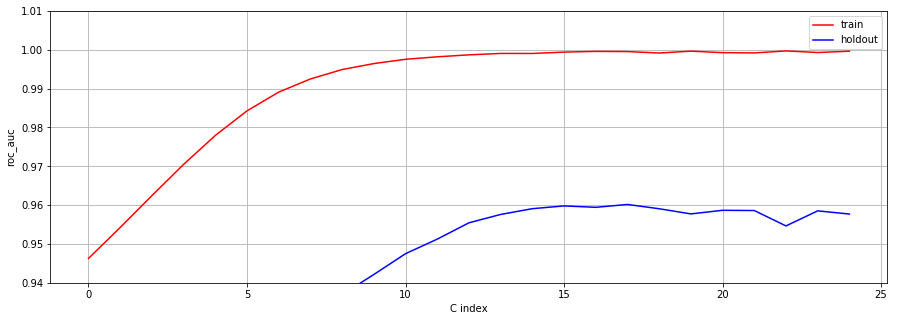

In [17]:
plt.figure(figsize=(15, 5))

plt.plot(range(len(C_range)), train_scores, color='red', label='train')
plt.plot(range(len(C_range)), holdout_scores, color='blue', label='holdout')

plt.ylim(0.94, 1.01)
#plt.xlim(18, 22)
plt.xlabel("C index")
plt.ylabel("roc_auc")
plt.legend()
plt.grid()
plt.show()

In [38]:
print('best holdout score:', np.max(holdout_scores))
print('best C:', C_range[np.argmax(holdout_scores)])
print('best C index:', np.argmax(holdout_scores))

ms_best_estimator = lrs[np.argmax(holdout_scores)]

best holdout score: 0.9601740731663095
best C: 17.78279410038923
best C index: 17


### logit GridSearchCV

In [26]:
lr = LogisticRegression(class_weight='balanced', random_state=14)
lr_grid = {'C': C_range}

In [27]:
%%time

tss = TimeSeriesSplit(n_splits=5)

gs = GridSearchCV(lr, lr_grid, scoring='roc_auc', cv=tss, n_jobs=-1, verbose=10, return_train_score=True)
gs.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 20.7min finished


Wall time: 21min 47s


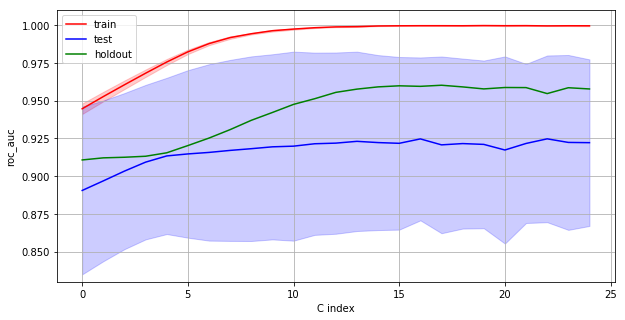

In [33]:
plt.figure(figsize=(10, 5))

# train
plt.plot(range(len(lr_grid['C'])), gs.cv_results_['mean_train_score'], color='red', label='train')
plt.fill_between(range(len(lr_grid['C'])), 
                 gs.cv_results_['mean_train_score'] - gs.cv_results_['std_train_score'], 
                 gs.cv_results_['mean_train_score'] + gs.cv_results_['std_train_score'], 
                 color='red', alpha=0.2)

# test
plt.plot(range(len(lr_grid['C'])), gs.cv_results_['mean_test_score'], color='blue', label='test')
plt.fill_between(range(len(lr_grid['C'])), 
                 gs.cv_results_['mean_test_score'] - gs.cv_results_['std_test_score'], 
                 gs.cv_results_['mean_test_score'] + gs.cv_results_['std_test_score'], 
                 color='blue', alpha=0.2)

# holdout
plt.plot(range(len(C_range)), holdout_scores, color='green', label='holdout')

plt.ylim(0.83, 1.01)
plt.xlabel("C index")
plt.ylabel("roc_auc")
plt.legend()
plt.grid()
plt.show()

In [34]:
print('gs best params:', gs.best_params_)
print('gs best score:', gs.best_score_)

gs best params: {'C': 316.22776601683796}
gs best score: 0.9246775133615484


In [35]:
%%time

tss_mts = TimeSeriesSplit(n_splits=5, max_train_size=X_train.shape[0] // 6)

gs_mts = GridSearchCV(lr, lr_grid, scoring='roc_auc', cv=tss_mts, n_jobs=-1, verbose=10, return_train_score=True)
gs_mts.fit(X_train_full, y_train_full)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  3.7min finished


Wall time: 4min 43s


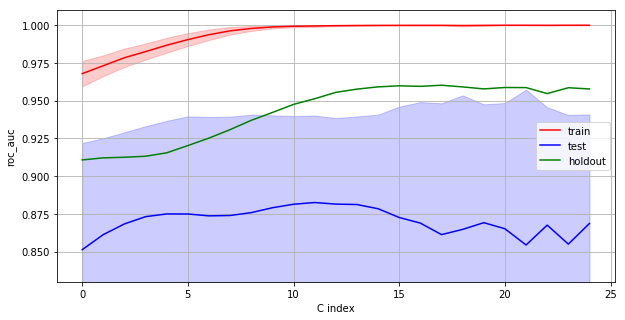

In [36]:
plt.figure(figsize=(10, 5))

# train
plt.plot(range(len(lr_grid['C'])), gs_mts.cv_results_['mean_train_score'], color='red', label='train')
plt.fill_between(range(len(lr_grid['C'])), 
                 gs_mts.cv_results_['mean_train_score'] - gs_mts.cv_results_['std_train_score'], 
                 gs_mts.cv_results_['mean_train_score'] + gs_mts.cv_results_['std_train_score'], 
                 color='red', alpha=0.2)

# test
plt.plot(range(len(lr_grid['C'])), gs_mts.cv_results_['mean_test_score'], color='blue', label='test')
plt.fill_between(range(len(lr_grid['C'])), 
                 gs_mts.cv_results_['mean_test_score'] - gs_mts.cv_results_['std_test_score'], 
                 gs_mts.cv_results_['mean_test_score'] + gs_mts.cv_results_['std_test_score'], 
                 color='blue', alpha=0.2)

# holdout
plt.plot(range(len(C_range)), holdout_scores, color='green', label='holdout')

plt.ylim(0.83, 1.01)
plt.xlabel("C index")
plt.ylabel("roc_auc")
plt.legend()
plt.grid()
plt.show()

In [37]:
print('gs_mts best params:', gs_mts.best_params_)
print('gs_mts best score:', gs_mts.best_score_)

gs_mts best params: {'C': 0.5623413251903491}
gs_mts best score: 0.8825033948059766


### choose best estimator

In [39]:
#best_estimator = gs.best_estimator_
best_estimator = ms_best_estimator
#best_ensemble = lrs[16:20]

# best_estimator = LogisticRegression(C=1.0, class_weight='balanced', random_state=14)
# best_estimator.fit(X_train, y_train)

In [40]:
estimator_coeffs = best_estimator.coef_[0][100001:]
print('max estimator coefficient:', np.max(estimator_coeffs))
print('min estimator coefficient:', np.min(estimator_coeffs))
print('mean estimator coefficient:', np.mean(estimator_coeffs))

max estimator coefficient: 0.0
min estimator coefficient: -0.9913002782342334
mean estimator coefficient: -0.049040669083211176


In [41]:
holdout_score = roc_auc_score(y_holdout, best_estimator.predict_proba(X_holdout)[:, 1])
print('holdout_score =', holdout_score)

holdout_score = 0.9601740731663095


### refit, predict and make submission

In [47]:
%%time

# refit
#best_estimator.fit(X_train_full, y_train_full)
best_estimator.fit(X_train_truncated, y_train_truncated)

# prediction
prediction = best_estimator.predict_proba(X_test)

Wall time: 43 s


In [48]:
write_to_submission_file(prediction, filename='prediction', timestamp=True)